In [1]:
import matplotlib.pyplot as plt
import supy as sp
import pandas as pd
import numpy as np
from pathlib import Path
from night import night
get_ipython().run_line_magic('matplotlib', 'inline')
%config InlineBackend.figure_format = 'svg'

In [2]:
path_runcontrol = Path('baserun')/ 'RunControl_ERA5.nml'
df_state_init = sp.init_supy(path_runcontrol)
grid = df_state_init.index[0]
df_forcing = sp.load_forcing_grid(path_runcontrol, grid)

2020-06-22 09:22:06,837 - SuPy - INFO - All cache cleared.
2020-06-22 09:22:08,290 - SuPy - INFO - All cache cleared.


#### Three scenario Used
1. Initial conditions used in sample data - Used Suffix: none
2. Building fraction = 0. grass = .41 - Population day/night = 0 - Used Suffix: _r         ("Rural" Conditions)
3. Building fraction = 0.05 grass = .36 - Population day/night = 5% of initial - Used Suffix: _rb      ("Rural"conditions with Building)

In [3]:
df_state_r = df_state_init.copy()
df_state_r.loc[:, ('sfr', '(1,)')] = 0 #Building
df_state_r.loc[:, ('sfr', '(4,)')] = 0.41 #Grass
df_state_r.popdensdaytime = 0
df_state_r.popdensnighttime = 0 
sp.check_state(df_state_r)

df_state_rb = df_state_init.copy()
df_state_rb.loc[:, ('sfr', '(1,)')] = .05 #Building
df_state_rb.loc[:, ('sfr', '(4,)')] = 0.36 #Grass
df_state_rb.popdensdaytime = df_state_init.popdensdaytime * 0.05
df_state_rb.popdensnighttime = df_state_init.popdensnighttime * 0.05 
sp.check_state(df_state_rb)

2020-06-22 09:22:13,619 - SuPy - INFO - SuPy is validating `df_state`...
2020-06-22 09:22:13,775 - SuPy - INFO - All checks for `df_state` passed!
2020-06-22 09:22:13,775 - SuPy - INFO - SuPy is validating `df_state`...
2020-06-22 09:22:13,931 - SuPy - INFO - All checks for `df_state` passed!


In [4]:
# Run SuPy initial conditions
df_output, df_state_final = sp.run_supy(df_forcing, df_state_init);
df_output_suews = df_output['SUEWS'];

# Run SuPy with modified environment add _r for recognition later on
df_r_output, df_state_r_final = sp.run_supy(df_forcing, df_state_r);
df_r_output_suews = df_r_output['SUEWS'];
df_r_output_suews = df_r_output_suews.add_suffix('_r');

# Run SuPy with modified environment add _rb for recognition later on
df_rb_output, df_state_rb_final = sp.run_supy(df_forcing, df_state_rb);
df_rb_output_suews = df_rb_output['SUEWS'];
df_rb_output_suews = df_rb_output_suews.add_suffix('_rb');

2020-06-22 09:22:16,359 - SuPy - INFO - ====================
2020-06-22 09:22:16,359 - SuPy - INFO - Simulation period:
2020-06-22 09:22:16,359 - SuPy - INFO -   Start: 2010-12-31 23:05:00
2020-06-22 09:22:16,359 - SuPy - INFO -   End: 2013-01-01 00:00:00
2020-06-22 09:22:16,359 - SuPy - INFO - 
2020-06-22 09:22:16,359 - SuPy - INFO - No. of grids: 1
2020-06-22 09:22:16,359 - SuPy - INFO - SuPy is running in serial mode
2020-06-22 09:23:06,295 - SuPy - INFO - Execution time: 49.9 s
2020-06-22 09:23:06,295 - SuPy - INFO - ====================

2020-06-22 09:23:06,295 - SuPy - INFO - ====================
2020-06-22 09:23:06,311 - SuPy - INFO - Simulation period:
2020-06-22 09:23:06,311 - SuPy - INFO -   Start: 2010-12-31 23:05:00
2020-06-22 09:23:06,311 - SuPy - INFO -   End: 2013-01-01 00:00:00
2020-06-22 09:23:06,311 - SuPy - INFO - 
2020-06-22 09:23:06,311 - SuPy - INFO - No. of grids: 1
2020-06-22 09:23:06,311 - SuPy - INFO - SuPy is running in serial mode
2020-06-22 09:24:01,453 - S

In [5]:
# RSL
df_output_rsl = df_output['RSL']
df_output_rsl_g = df_output_rsl.loc[grid]
df_output_rsl_r = df_r_output['RSL']
df_output_rsl_r = df_output_rsl_r.add_suffix('_r');
df_output_rsl_r_g = df_output_rsl_r.loc[grid]
df_output_rsl_rb = df_rb_output['RSL']
df_output_rsl_rb = df_output_rsl_rb.add_suffix('_rb');
df_output_rsl_rb_g = df_output_rsl_rb.loc[grid]

In [6]:
# Merge to one dataframe for easier plotting
df_output_suews_g = df_output_suews.loc[grid];
df_r_output_suews_g = df_r_output_suews.loc[grid];
df_rb_output_suews_g = df_rb_output_suews.loc[grid];

df_merge = pd.concat([df_output_suews_g, df_r_output_suews_g,df_rb_output_suews_g],axis=1,join='inner');
df_rsl = pd.concat([df_output_rsl_g,df_output_rsl_r_g,df_output_rsl_rb_g],axis=1,join='inner');

##### Radiation fluxes 23 July - 26 July 2012

In [36]:
# Start and end date
s = '2012 7 20';
e = '2012 7 29'; 
size = 12, 7

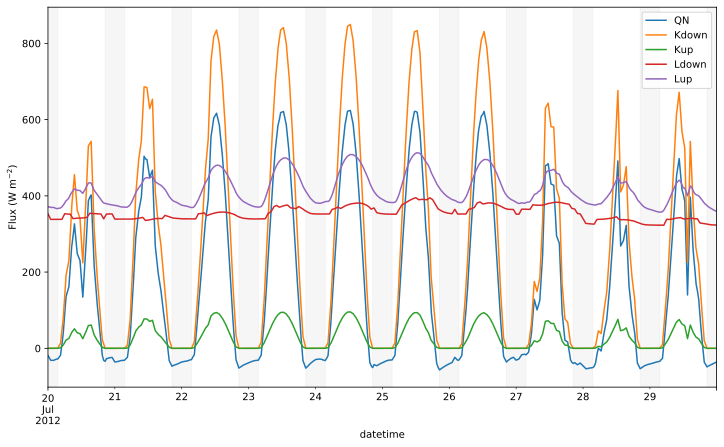

In [37]:
ax_output = df_merge.loc[s:e,['QN', 'Kdown', 'Kup', 'Ldown', 'Lup']].plot(figsize=(size));
ax_output.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)');
ax_output.legend();
night(ax_output);

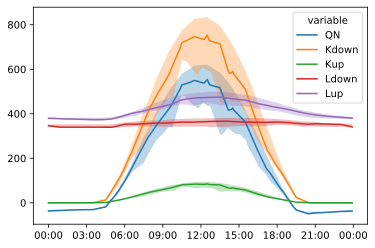

In [38]:
 sp.util.plot_day_clm(df_merge.loc[s:e,['QN', 'Kdown', 'Kup', 'Ldown', 'Lup']]);

##### Wind

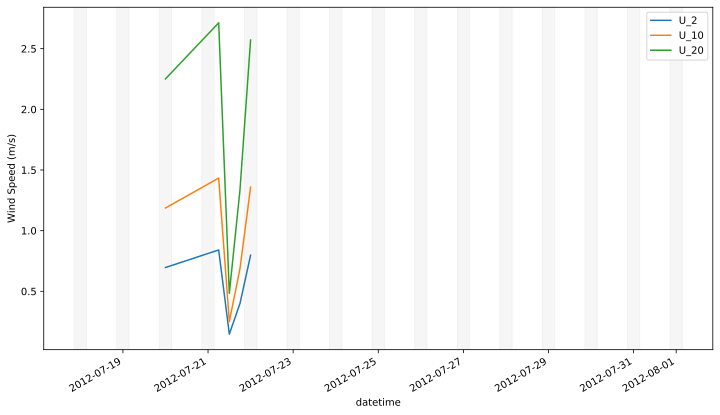

In [39]:
ax_output = df_rsl.loc[s:e,['U_2','U_10','U_20']].plot(figsize= size);
ax_output.set_ylabel('Wind Speed (m/s)');
ax_output.legend();
night(ax_output)

##### Temperature 2 magl

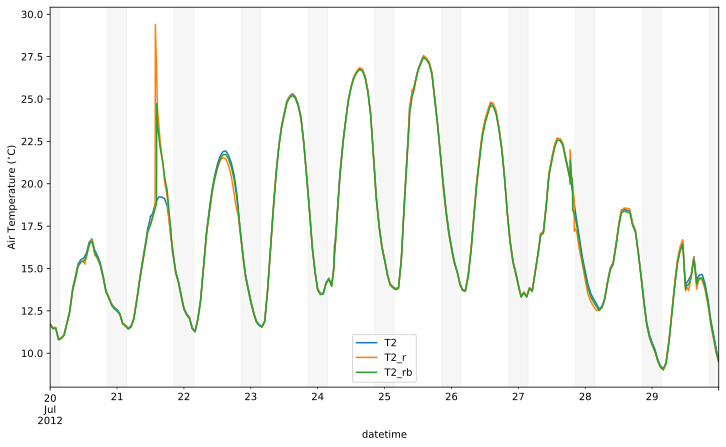

In [41]:
ax_output = df_merge.loc[s:e,['T2','T2_r','T2_rb']].plot(figsize=size);
ax_output.set_ylabel('Air Temperature ($^{\\circ}}$C)');
ax_output.legend();
night(ax_output)

##### Relative Humidity (%)

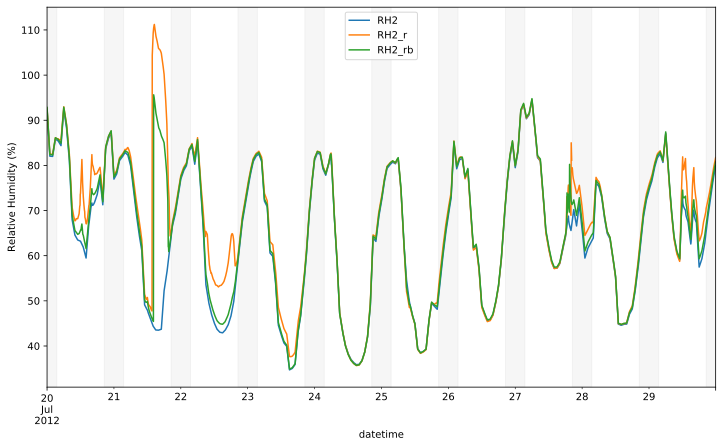

In [42]:
ax_output = df_merge.loc[s:e,['RH2','RH2_r','RH2_rb']].plot(figsize=size);
ax_output.set_ylabel('Relative Humidity (%)');
ax_output.legend();
night(ax_output)

##### Specific Humidity (g/kg^-1)

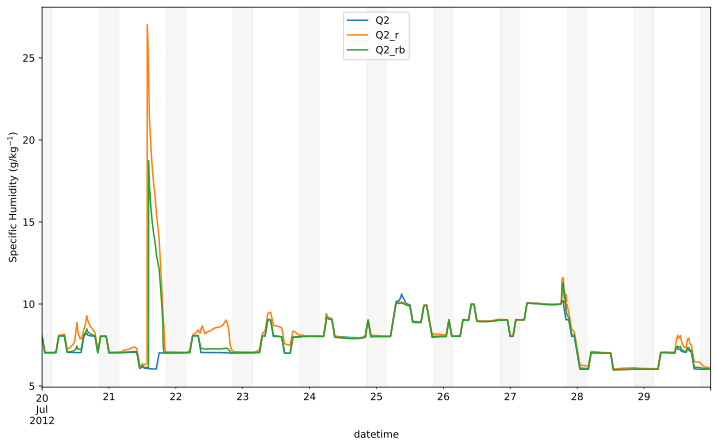

In [43]:
ax_output = df_merge.loc[s:e,['Q2','Q2_r','Q2_rb']].plot(figsize=size);
ax_output.set_ylabel('Specific Humidity (g/$ \mathrm{kg^{-1}}$)');
ax_output.legend();
night(ax_output)

##### Friction Velocity

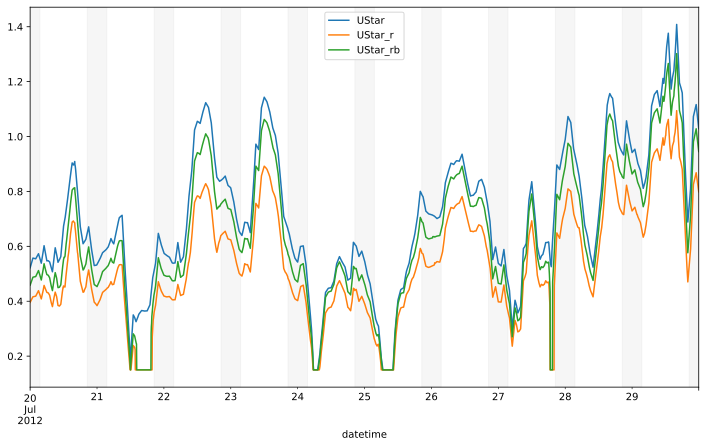

In [44]:
ax_output = df_merge.loc[s:e,['UStar','UStar_r','UStar_rb']].plot(figsize=size);
ax_output.legend();
night(ax_output)

##### Resistance

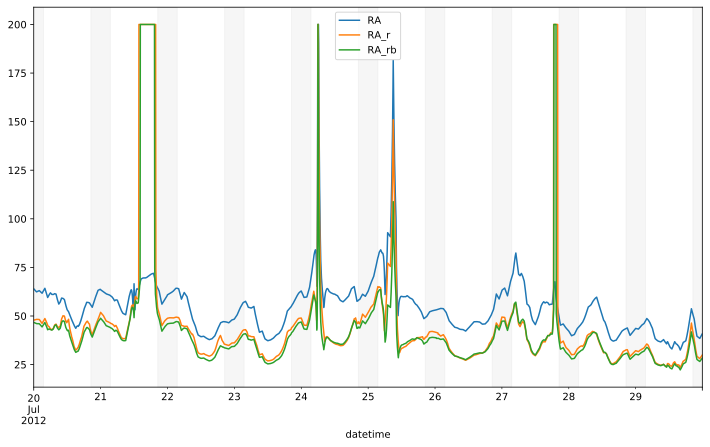

In [45]:
ax_output = df_merge.loc[s:e,['RA','RA_r','RA_rb']].plot(figsize=size);
ax_output.legend();
night(ax_output)

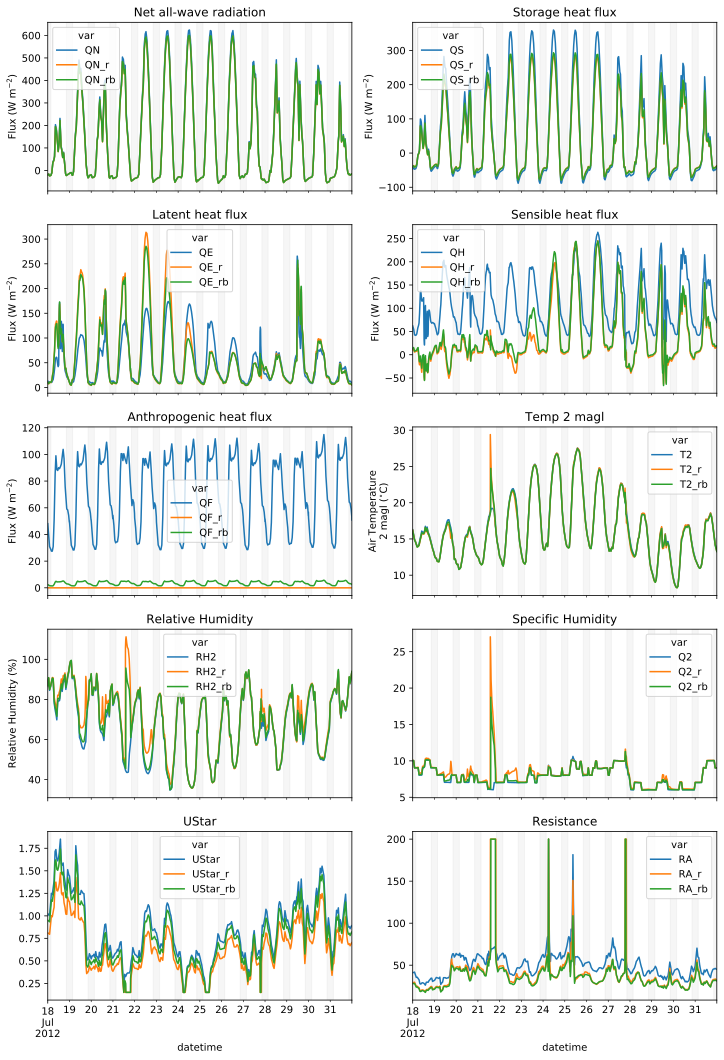

In [18]:
fsize = (12,18)
fig, axes = plt.subplots(5, 2, sharex=True)
# QN
a = df_merge.loc[s : e ,['QN','QN_r','QN_rb']].plot(ax=axes[0,0],figsize=fsize,title='Net all-wave radiation',
    )
# QS
b = df_merge.loc[s : e ,['QS','QS_r','QS_rb']].plot(ax=axes[0,1],figsize=fsize,title='Storage heat flux',
    )
# QE
c = df_merge.loc[s : e ,['QE','QE_r','QE_rb']].plot(ax=axes[1,0],figsize=fsize,title='Latent heat flux',
    )
# QH
d = df_merge.loc[s : e ,['QH','QH_r','QH_rb']].plot(ax=axes[1,1],figsize=fsize,title='Sensible heat flux',
    )
# QF
e1 = df_merge.loc[s : e ,['QF','QF_r','QF_rb']].plot(ax=axes[2,0],figsize=fsize,title='Anthropogenic heat flux',
    )
# T2
f = df_merge.loc[s : e ,['T2','T2_r','T2_rb']].plot(ax=axes[2,1],figsize=fsize,title='Temp 2 magl',
    )
# RH
g = df_merge.loc[s : e ,['RH2','RH2_r','RH2_rb']].plot(ax=axes[3,0],figsize=fsize,title='Relative Humidity',
    )
# RH
h = df_merge.loc[s : e ,['Q2','Q2_r','Q2_rb']].plot(ax=axes[3,1],figsize=fsize,title='Specific Humidity',
    )
# Friction Velocity
i = df_merge.loc[s : e ,['UStar','UStar_r','UStar_rb']].plot(ax=axes[4,0],figsize=fsize,title='UStar',
    )
# Resistance
j = df_merge.loc[s : e ,['RA','RA_r','RA_rb']].plot(ax=axes[4,1],figsize=fsize,title='Resistance',
    )
axes[0,0].set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
axes[1,0].set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
axes[1,1].set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
axes[0,1].set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
axes[2,0].set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
axes[2,1].set_ylabel('Air Temperature\n2 magl ($^{\\circ}}$C)')
axes[3,0].set_ylabel('Relative Humidity (%)');

for var in [a,b,c,d,e1,f,g,h,i,j]:
    night(var)
    

# Test RSL-Plot

In [27]:
s0 = '2012 07 20 00:00'
s6 = '2012 07 21 06:00'
s12= '2012 07 21 12:00'
s18= '2012 07 21 18:00'
s24= '2012 07 22 00:00'

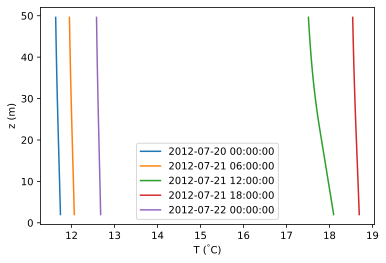

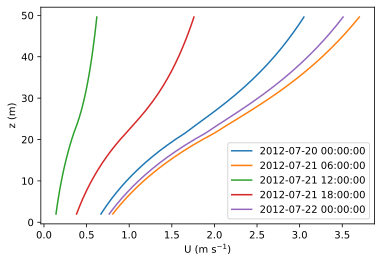

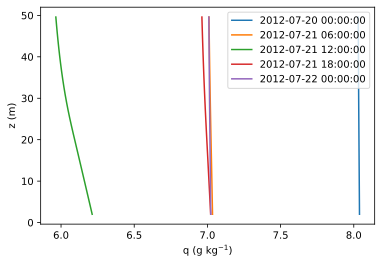

In [29]:
t0  = df_output_rsl_g.loc[s0 : s0]
t6  = df_output_rsl_g.loc[s6 : s6]
t12 = df_output_rsl_g.loc[s12:s12]
t18 = df_output_rsl_g.loc[s18:s18]
t24 = df_output_rsl_g.loc[s24:s24]
df_rsl = pd.concat([t0,t6,t12,t18,t24],join='inner');

sp.util.plot_rsl(df_rsl,'T');
sp.util.plot_rsl(df_rsl,'U');
sp.util.plot_rsl(df_rsl,'q');

##### Rural Conditions

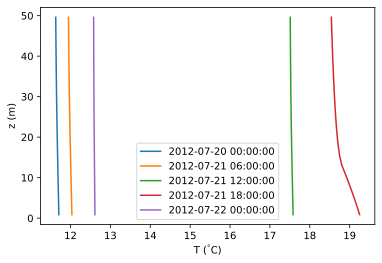

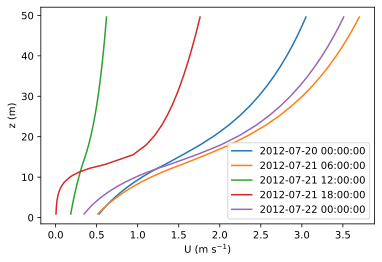

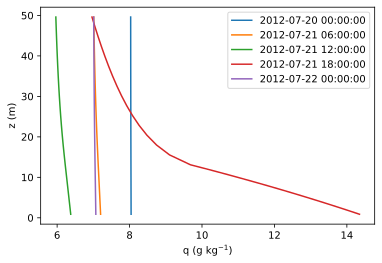

In [30]:
t0_r  = df_output_rsl_r_g.loc[s0 : s0]
t6_r  = df_output_rsl_r_g.loc[s6 : s6]
t12_r = df_output_rsl_r_g.loc[s12:s12]
t18_r = df_output_rsl_r_g.loc[s18:s18]
t24_r = df_output_rsl_r_g.loc[s24:s24]
df_rsl_r = pd.concat([t0_r,t6_r,t12_r,t18_r,t24_r],join='inner');

sp.util.plot_rsl(df_rsl_r,'T');
sp.util.plot_rsl(df_rsl_r,'U');
sp.util.plot_rsl(df_rsl_r,'q');

##### Rural Buildings

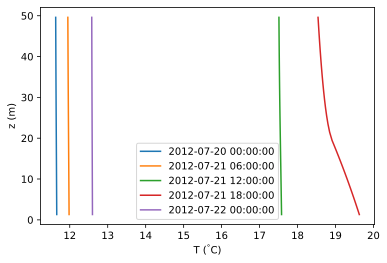

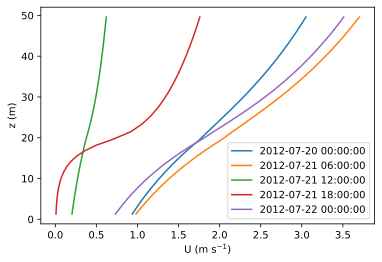

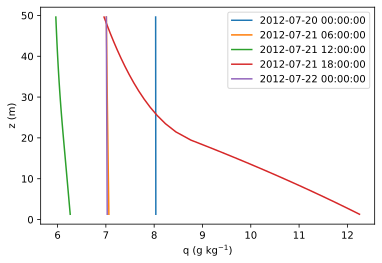

In [31]:
t0_rb  = df_output_rsl_rb_g.loc[s0 : s0]
t6_rb  = df_output_rsl_rb_g.loc[s6 : s6]
t12_rb = df_output_rsl_rb_g.loc[s12:s12]
t18_rb = df_output_rsl_rb_g.loc[s18:s18]
t24_rb = df_output_rsl_rb_g.loc[s24:s24]
df_rsl_rb = pd.concat([t0_rb,t6_rb,t12_rb,t18_rb,t24_rb],join='inner');

sp.util.plot_rsl(df_rsl_rb,'T');
sp.util.plot_rsl(df_rsl_rb,'U');
sp.util.plot_rsl(df_rsl_rb,'q');

# Temperature 
##### initial
##### rural
##### ruralbuilding

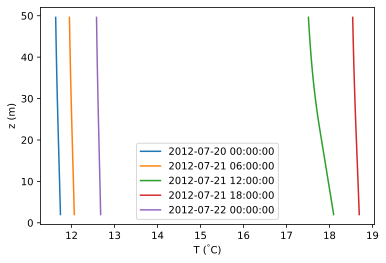

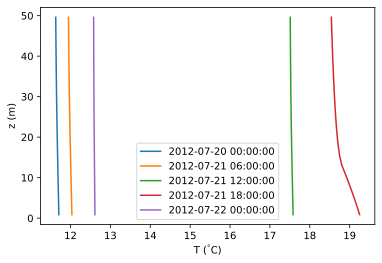

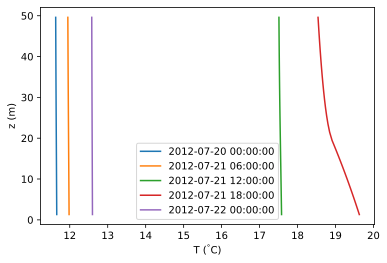

In [32]:
sp.util.plot_rsl(df_rsl,'T');
sp.util.plot_rsl(df_rsl_r,'T');
sp.util.plot_rsl(df_rsl_rb,'T');

##### Initial Conditions

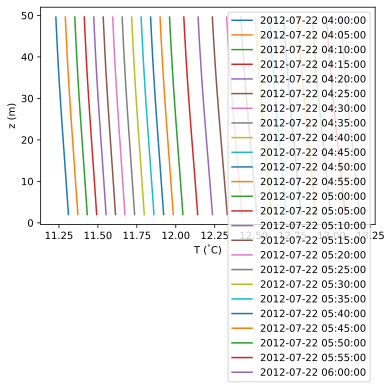

In [33]:
sp.util.plot_rsl(df_output_rsl_g.loc['2012 07 21 04:00' : '2012 07 21 06:00'],'T');


##### Rural Conditions

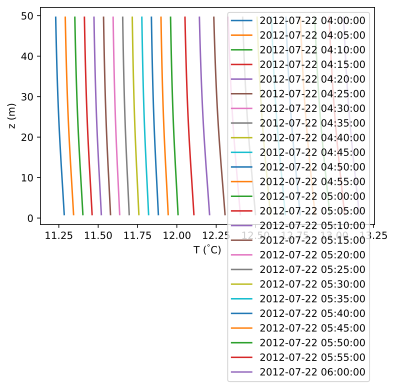

In [34]:
sp.util.plot_rsl(df_output_rsl_r_g.loc['2012 07 21 04:00' : '2012 07 21 06:00'],'T');


##### Rural/building Conditions

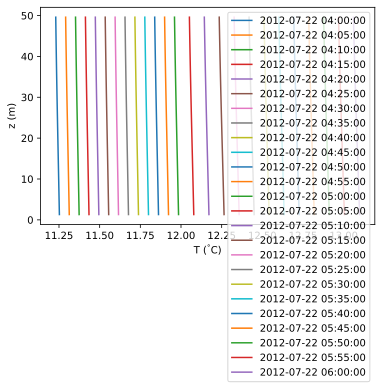

In [35]:
sp.util.plot_rsl(df_output_rsl_rb_g.loc['2012 07 21 04:00' : '2012 07 21 06:00'],'T');